In [3]:
# Cell 2 — imports
import pandas as pd, numpy as np, pickle, optuna, matplotlib.pyplot as plt, seaborn as sns, xgboost as xgb
from pathlib import Path
sns.set_theme(style="whitegrid")


In [5]:
# Cell 3
DATA_DIR = Path("../data/processed")
MOD_DIR  = Path("../artifacts/models")

feat = pd.read_csv(DATA_DIR / "features_daily.csv")
feat["timestamp"] = pd.to_datetime(feat["timestamp"], utc=True).dt.tz_convert("Europe/Kyiv")
print(feat.shape)


(23600, 36)


In [7]:
# Cell 4
def to_hourly(df):
    df = df.set_index("timestamp")
    agg = {c: "mean" for c in df if df[c].dtype != "object"}
    hr  = df.resample("1h").agg(agg).dropna(subset=["load_kw", "pv_kw"])
    return hr.reset_index()

def make_supervised(hr, target):
    X, y = [], []
    for i in range(len(hr)-24):
        X.append(hr.iloc[i].drop("timestamp").values)
        y.append(hr[target].iloc[i+1:i+25].values)
    return np.vstack(X), np.vstack(y)


In [9]:
# Cell 5
hourly = to_hourly(feat)
X_l, y_l = make_supervised(hourly, "load_kw")
X_p, y_p = make_supervised(hourly, "pv_kw")

models_l = pickle.load(open(MOD_DIR/"consumption_xgb.pkl","rb"))
models_p = pickle.load(open(MOD_DIR/"generation_xgb.pkl","rb"))

def metrics(models, X, Y):
    preds = np.column_stack([m.predict(X) for m in models])
    mae   = np.mean(np.abs(preds - Y))
    rmse  = np.sqrt(np.mean((preds - Y)**2))
    return mae, rmse

mae_l, rmse_l = metrics(models_l, X_l, y_l)
mae_p, rmse_p = metrics(models_p, X_p, y_p)

print(f"Load  —  MAE {mae_l:.3f} kW   RMSE {rmse_l:.3f} kW")
print(f"PV    —  MAE {mae_p:.3f} kW   RMSE {rmse_p:.3f} kW")


Load  —  MAE 0.054 kW   RMSE 0.076 kW
PV    —  MAE 0.018 kW   RMSE 0.031 kW


In [10]:
# Cell 6
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("lr", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("col", 0.6, 1.0),
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "random_state": 42,
    }
    # Тренуємо тільки один горизонт (t+1h) як проксі-метрику
    y1 = y_l[:,0]
    model = xgb.XGBRegressor(**params)
    model.fit(X_l, y1, verbose=False)
    pred = model.predict(X_l)
    return np.mean(np.abs(pred - y1))   # MAE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True)
study.best_params


[I 2025-04-30 18:25:49,351] A new study created in memory with name: no-name-05745f4a-86a1-48b9-ad36-b591411479be


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-30 18:25:55,765] Trial 0 finished with value: 0.00041433523827802513 and parameters: {'n_estimators': 389, 'max_depth': 10, 'lr': 0.18262315848711314, 'subsample': 0.8621020845783554, 'col': 0.7774928006931994}. Best is trial 0 with value: 0.00041433523827802513.
[I 2025-04-30 18:26:02,992] Trial 1 finished with value: 0.014040924600711558 and parameters: {'n_estimators': 714, 'max_depth': 8, 'lr': 0.026427481120101473, 'subsample': 0.8425339531532364, 'col': 0.8566663368488168}. Best is trial 0 with value: 0.00041433523827802513.
[I 2025-04-30 18:26:03,676] Trial 2 finished with value: 0.07736646805834026 and parameters: {'n_estimators': 364, 'max_depth': 5, 'lr': 0.05746467142311589, 'subsample': 0.6130206665555661, 'col': 0.8015901699703283}. Best is trial 0 with value: 0.00041433523827802513.
[I 2025-04-30 18:26:05,345] Trial 3 finished with value: 0.0015595969188052527 and parameters: {'n_estimators': 709, 'max_depth': 6, 'lr': 0.11737686064718236, 'subsample': 0.686305

{'n_estimators': 792,
 'max_depth': 9,
 'lr': 0.1419629933973939,
 'subsample': 0.6389354785111651,
 'col': 0.9612612618324783}

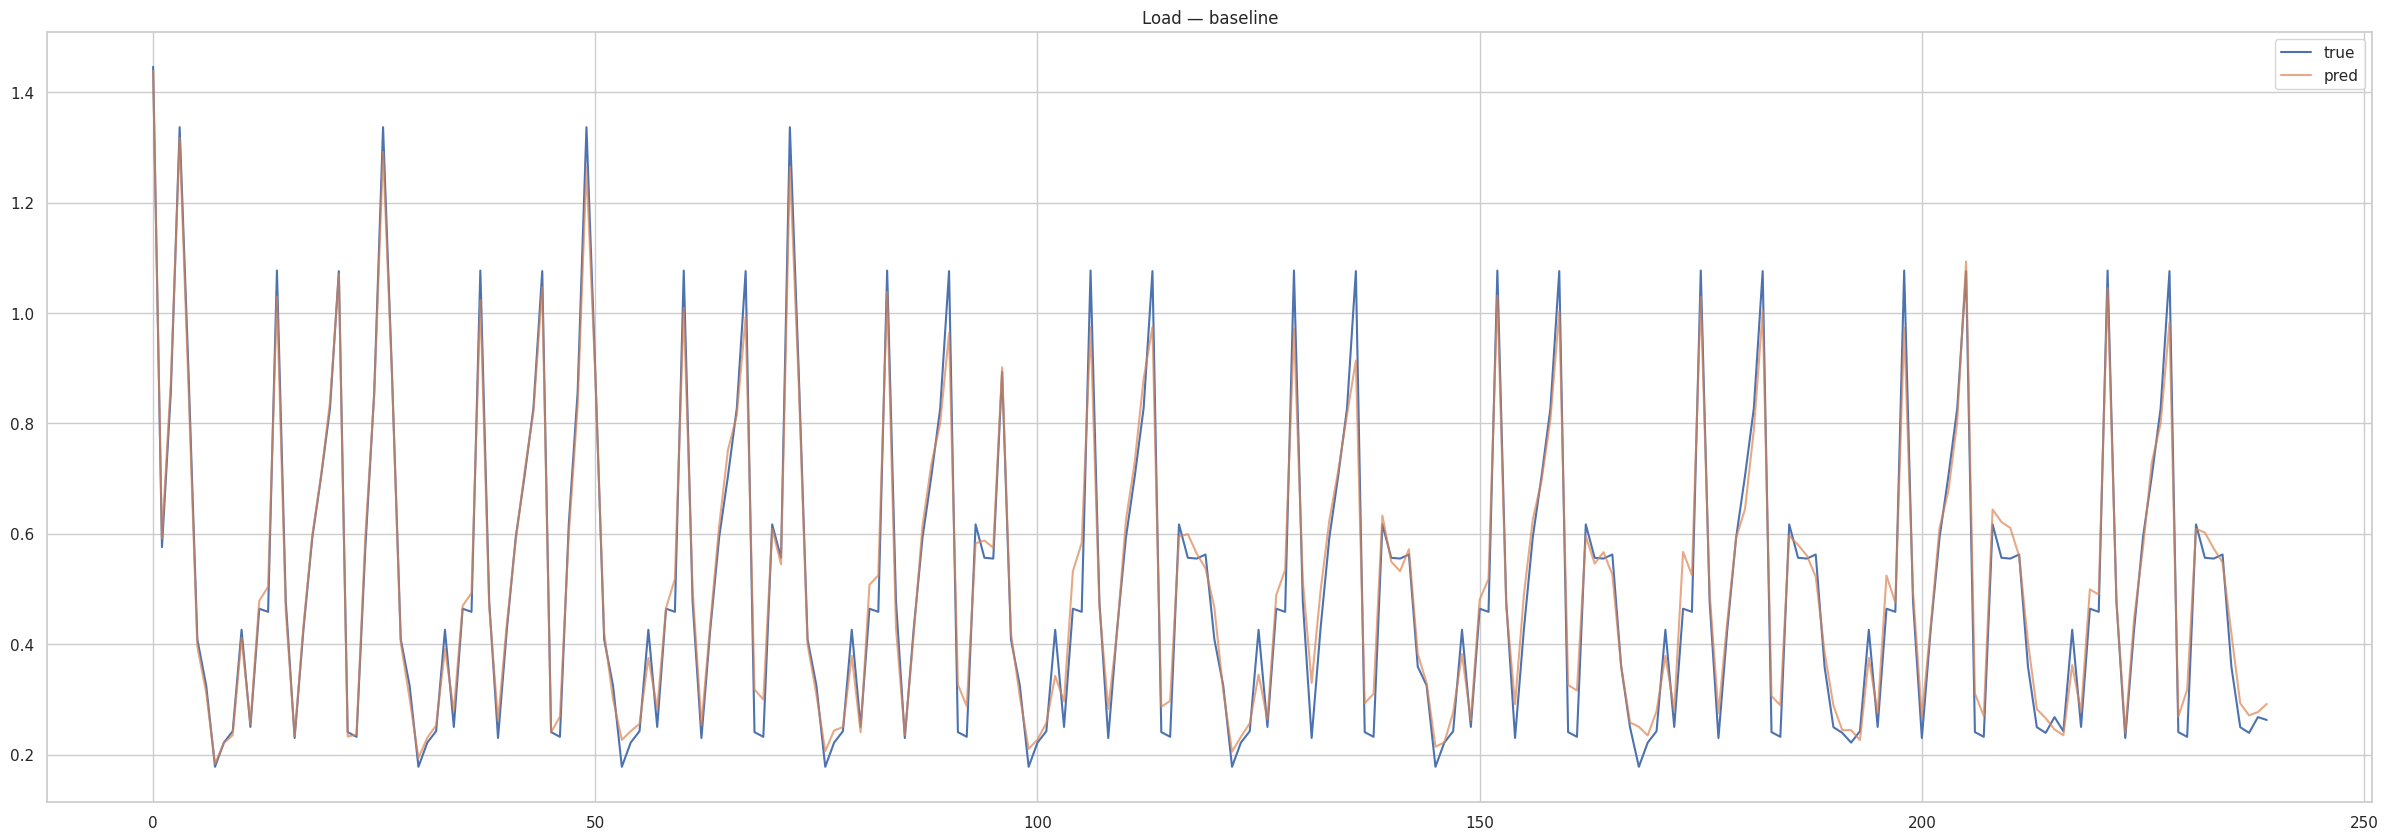

In [12]:
# Cell 7
def plot_pred_vs_true(models, X, Y, title):
    preds = np.column_stack([m.predict(X) for m in models])
    plt.figure(figsize=(30,10))
    plt.plot(Y.flatten()[:240], label="true")
    plt.plot(preds.flatten()[:240], label="pred", alpha=.7)
    plt.title(title); plt.legend(); plt.show()

plot_pred_vs_true(models_l, X_l, y_l, "Load — baseline")
# plot_pred_vs_true(models_l_tuned, X_l, y_l, "Load — tuned")  # якщо маєш tuned
